# Animal Classification

I found the main dataset (zoo.csv) here: https://www.kaggle.com/uciml/zoo-animal-classification and the secondary datasets (zoo2.csv and zoo3.csv) here: https://www.kaggle.com/agajorte/zoo-animals-extended-dataset

This project is meant for me to practice using Python's scikit-learn library for machine learning. In this particular case, I will be using the decision tree classifier algorithm to classify animals into 7 categories.


In [1]:
# Import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import  train_test_split, GridSearchCV, cross_val_score
from sklearn import metrics

## Data Preprocessing

In [2]:
# Load data into data frames
animals = pd.read_csv('D:\Jane\Python\python files\datasets\zoo.csv')
animals2 = pd.read_csv('D:\Jane\Python\python files\datasets\zoo2.csv')
animals3 = pd.read_csv('D:\Jane\Python\python files\datasets\zoo3.csv')

# Join data frames
zoo_df = pd.concat([animals,animals2,animals3])

# Preview data
zoo_df.head()

,animal_name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,class_type
0,aardvark,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
1,antelope,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,1
2,bass,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,4
3,bear,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
4,boar,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1


* class_type is a label, so it needs to be separated from the features. Order of values doesn't matter, so it can be one hot encoded
* Most features seem to have boolean values (1=True and 0=False), where animal_name is categorical and legs is numerical 
* animal_name also needs to be removed because it is useless for classification
* Note: I am not too sure what catsize is supposed to mean

In [4]:
# Create new data frame for classification (with class_data removed)
X = zoo_df.drop(['animal_name','class_type'],axis=1)

# Store class_type for future comparisons with predicted data
y = zoo_df['class_type']

# One hot encode class_type
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)

In [5]:
# Get dimensions of data frame
print('Dimensions of X: {}'.format(X.shape))
print('Dimensions of y: {}'.format(y_encoded.shape))
print('\n')
# Check for any missing values
X.info()

Dimensions of X: (214, 16)
Dimensions of y: (214,)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 214 entries, 0 to 69
Data columns (total 16 columns):
hair        214 non-null int64
feathers    214 non-null int64
eggs        214 non-null int64
milk        214 non-null int64
airborne    214 non-null int64
aquatic     214 non-null int64
predator    214 non-null int64
toothed     214 non-null int64
backbone    214 non-null int64
breathes    214 non-null int64
venomous    214 non-null int64
fins        214 non-null int64
legs        214 non-null int64
tail        214 non-null int64
domestic    214 non-null int64
catsize     214 non-null int64
dtypes: int64(16)
memory usage: 28.4 KB


* 214 animals to classify, based on 16 features
* No missing values

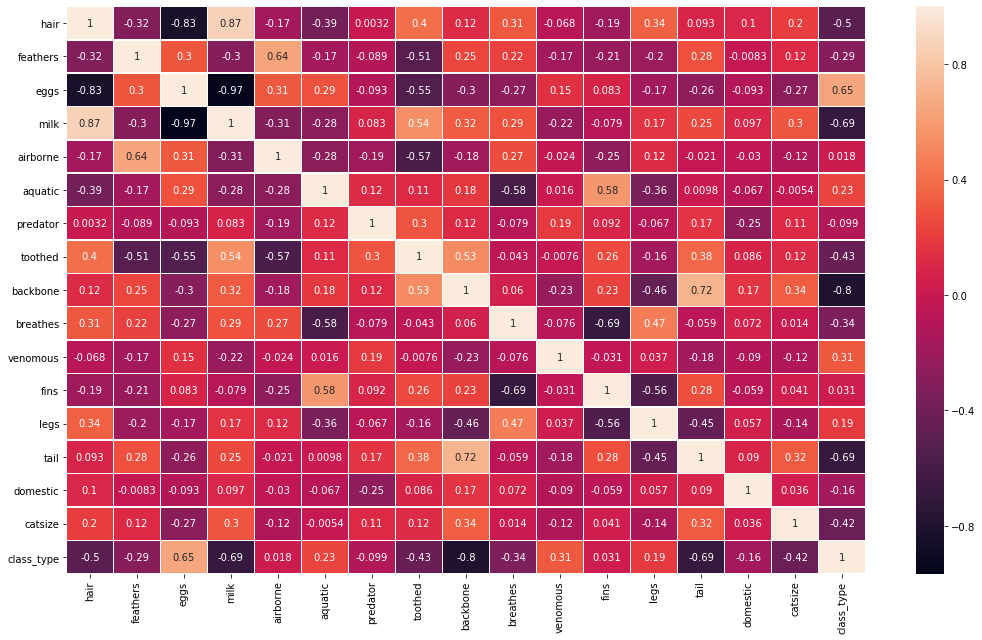

In [28]:
# Correlation matrix of zoo_df
zoo_corr = zoo_df.corr()
# Change figure size 
fig, ax1 = plt.subplots(figsize=(15,9))
# Create heat map of correlation matrix
sn.heatmap(zoo_corr, annot=True, linewidths=.5)
# Remove unnecessary output
plt.tight_layout()

* High positive correlation between having hair and producing milk
* High negative correlation between having hair and laying eggs
* Very high negative correlation between producing milk and laying eggs
* Moderate negative correlation between being airborne and being toothed
* Moderate negative correlation between laying eggs and being toothed
* Moderate negative correlation between having feathers and being toothed
* Moderate negative correlation between breathing and having fins
* class_type has moderate or high correlations with eggs, milk, backbone, and tail

## Classification using Decision Tree Algorithm

In [47]:
# Split data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=1)

In [47]:
# Parameter tuning
# Create the model
tree = DecisionTreeClassifier(random_state=1)
# Create the grid of possible hyperparameters for the model
grid = {'criterion': ['gini', 'entropy'], 'splitter': ['best', 'random'], 'max_features':[x for x in range(1,17)]}
# Finding the best parameters
grid_search = GridSearchCV(tree, param_grid=grid, cv=10)
grid_search.fit(X_train, y_train)
print('The best score is {}'.format(grid_search.best_score_))
print('The best parameters are {}'.format(grid_search.best_params_))

The best score is 0.9866666666666667
The best parameters are {'criterion': 'gini', 'max_features': 10, 'splitter': 'best'}


In [48]:
# Fit the model with the best parameters and then make predictions
tree = grid_search.best_estimator_
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
print('Training accuracy: {}'.format(tree.score(X_train, y_train)))
print('Testing accuracy: {}'.format(tree.score(X_test, y_test)))

Training accuracy: 0.9932885906040269
Testing accuracy: 0.9538461538461539


* The difference between training and testing accuracies is not that high, so there is no strong evidence for overfitting or underfitting of data

## Confusion Matrix

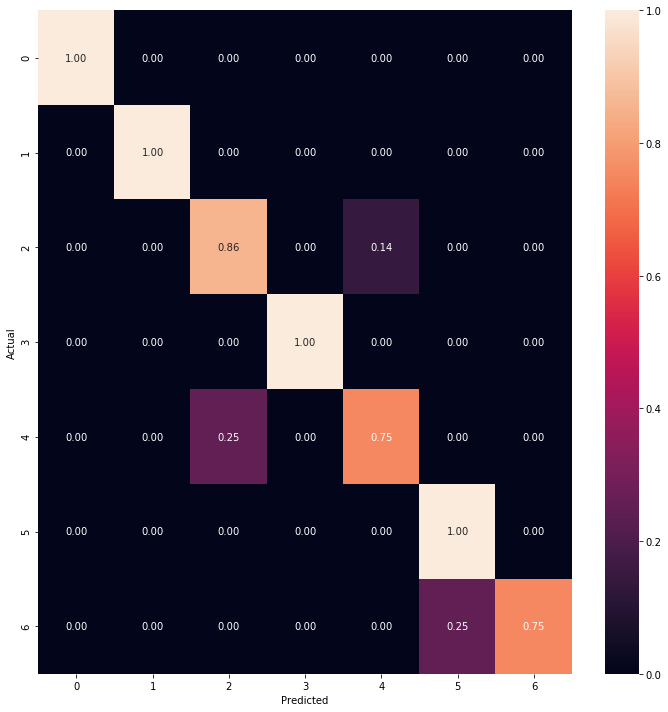

In [49]:
# Create normalized confusion matrix with a heatmap
cm = metrics.confusion_matrix(y_test, y_pred)
fig, ax1 = plt.subplots(figsize=(10,10))
cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
sn.heatmap(cm_norm, annot=True, fmt='.2f', xticklabels=[0,1,2,3,4,5,6], yticklabels=[0,1,2,3,4,5,6])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()

* 14% of class 2 (reptiles) is wrongly predicted as class 4 (amphibians) 
* 25% of class 4 is wrongly predicted as class 2
* 25% of class 6 (invertebrates) is wrongly predicted as class 5 (bugs)
* The wrong predictions seem plausible as reptiles and amphibians share similar characteristics, such as, hairlessness and ability to lay eggs. Same goes for bugs and invertebrates